In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms, datasets
# 모델 요약
from torchvision import models, utils
from torchsummary import summary

In [2]:
# 학습률, batch, epoch
lr = 1e-3
batch_size = 64
num_epoch = 10

# 학습된 network가 불러올 디렉터리
ckpt_dir = 'D:/torchtorch/checkpoint3'
# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# 네트워크 구축
class Fashion_MNIST_NET(nn.Module) :
    def __init__(self) :
        super(Fashion_MNIST_NET, self).__init__()
        
        # 입력채널 : gray scale이므로 1, 출력 채널(=필터 개수)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True)
        # 32x28x28
        self.batch1 = nn.BatchNorm2d(32)
        # 32x14x14
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # 16x26x26
        
        # 입력채널 : 이전 채널의 출력 개수, 출력 채널(=필터 개수)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0, bias=True)
#         self.drop2 = nn.Dropout2d(p=0.5)
        self.batch2 = nn.BatchNorm2d(64)
        # 32x5x5
        self.relu2 = nn.ReLU()
        # 32x11x11
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # Global Average Pooling 뒤에 FC와 연결
        self.avg_pool = nn.AvgPool2d(1)
        
        self.fc1 = nn.Linear(in_features=2304, out_features=300)
        # 32x5x5
        self.drop1 = nn.Dropout2d(p=0.5)
        
        self.fc3 = nn.Linear(in_features=300, out_features=120)
        # 입력 채널 : 이전 채널의 출력 개수, 마지막층 출력 = 분류하려는 class 개수
        self.fc2 = nn.Linear(in_features=120, out_features=10, bias=True)
     
    # 앞에서 초기화 한 layer들을 연결해준다.
    def forward(self, x) :
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu2(x)
        x = self.pool2(x)
       
        x = self.avg_pool(x)
        # Flatten() -> 입력 채널 맞춰줘야함
        x = x.view(-1, 2304)
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.fc3(x)
        x = self.fc2(x)
        
        return x

In [4]:
## 네트워크를 저장하거나 불러오는 함수 작성하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               '%s/model_epoch%d.pth' % (ckpt_dir, epoch))

def load(ckpt_dir, net, optim):
    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort()

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))
    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    return net, optim

In [5]:
## MNIST 데이터 불러오기
## 이미지 전처리 과정
# 1. 이미지 텐서 변환 및 정규화 등 수행(.Compose) 
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

# 2. 데이터셋 불러오기
dataset = datasets.FashionMNIST(download=True, root='./.data/', train=False, transform=transform)

# 3. 데이터셋 나누기
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# 4. 1배치에 들어갈 데이터 
# 1epoch = 60000개 = 64batch
# 1batch = 60000/64(batch_size) = 938
num_data = len(loader.dataset)
num_batch = np.ceil(num_data / batch_size)

In [6]:
print(dataset)
print(loader)
print(num_data)
print(num_batch)
print(10000/64)

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./.data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
10000
157.0
156.25


In [7]:
## 네트워크 설정 및 필요한 손실함수 구현하기
net = Fashion_MNIST_NET().to(device)
params = net.parameters()

fn_loss = nn.CrossEntropyLoss().to(device)
fn_pred = lambda output: torch.softmax(output, dim=1)
fn_acc = lambda pred, label: ((pred.max(dim=1)[1] == label).type(torch.float)).mean()
optim = torch.optim.Adam(params, lr=lr)

# train과 다른점 - load
net, optim = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

In [8]:
print(net)
print(optim)

Fashion_MNIST_NET(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=1, stride=1, padding=0)
  (fc1): Linear(in_features=2304, out_features=300, bias=True)
  (drop1): Dropout2d(p=0.5, inplace=False)
  (fc3): Linear(in_features=300, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


In [9]:
## evaluation 시작하기
predictions_list = []
labels_list = []

with torch.no_grad():
    net.eval()

    loss_arr = []
    acc_arr = []

    # 다른점 - backpropagation 과정 제거
    for batch, (input, label) in enumerate(loader, 1):
        
        labels_list.append(label)
        input = input.to(device)
        label = label.to(device)

        output = net(input)
        
        pred = fn_pred(output)
        loss = fn_loss(output, label)
        acc = fn_acc(pred, label)

        predictions_list.append(torch.max(output,1)[1])
        loss_arr += [loss.item()]
        acc_arr += [acc.item()]

        print('TEST: BATCH %04d/%04d | LOSS: %.4f | ACC %.4f' %
              (batch, num_batch, np.mean(loss_arr), np.mean(acc_arr)))

TEST: BATCH 0001/0157 | LOSS: 0.3960 | ACC 0.8906
TEST: BATCH 0002/0157 | LOSS: 0.3207 | ACC 0.8984
TEST: BATCH 0003/0157 | LOSS: 0.3079 | ACC 0.8958
TEST: BATCH 0004/0157 | LOSS: 0.2626 | ACC 0.9180
TEST: BATCH 0005/0157 | LOSS: 0.2342 | ACC 0.9281
TEST: BATCH 0006/0157 | LOSS: 0.2405 | ACC 0.9245
TEST: BATCH 0007/0157 | LOSS: 0.2293 | ACC 0.9241
TEST: BATCH 0008/0157 | LOSS: 0.2353 | ACC 0.9258
TEST: BATCH 0009/0157 | LOSS: 0.2317 | ACC 0.9236
TEST: BATCH 0010/0157 | LOSS: 0.2255 | ACC 0.9250
TEST: BATCH 0011/0157 | LOSS: 0.2234 | ACC 0.9233
TEST: BATCH 0012/0157 | LOSS: 0.2346 | ACC 0.9232
TEST: BATCH 0013/0157 | LOSS: 0.2390 | ACC 0.9279
TEST: BATCH 0014/0157 | LOSS: 0.2348 | ACC 0.9275
TEST: BATCH 0015/0157 | LOSS: 0.2321 | ACC 0.9281
TEST: BATCH 0016/0157 | LOSS: 0.2494 | ACC 0.9248
TEST: BATCH 0017/0157 | LOSS: 0.2466 | ACC 0.9210
TEST: BATCH 0018/0157 | LOSS: 0.2523 | ACC 0.9201
TEST: BATCH 0019/0157 | LOSS: 0.2562 | ACC 0.9186
TEST: BATCH 0020/0157 | LOSS: 0.2586 | ACC 0.9187


In [10]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

# print(predictions_l)
# print(labels_l)

In [11]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.85      0.90      0.87      1000
           3       0.89      0.94      0.91      1000
           4       0.88      0.88      0.88      1000
           5       0.98      0.99      0.99      1000
           6       0.78      0.72      0.75      1000
           7       0.96      0.97      0.96      1000
           8       0.99      0.99      0.99      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000




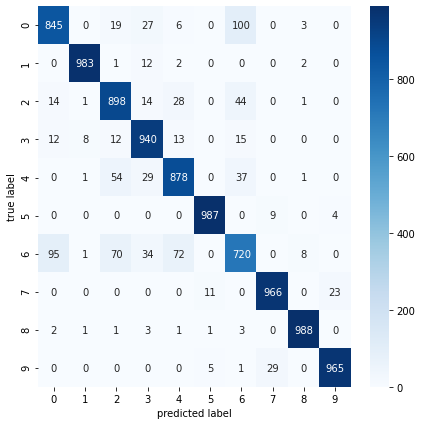

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 혼동 행렬을 만듭니다.
plt.figure(figsize = (7, 7))
cm = confusion_matrix(labels_l, predictions_l)
sns.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()